In [1]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

from tracker.main import (
    getROIFromVideo,
    cropWithROI,
    getTemplatesFromVideo,
    getTemplateMatches,
    getOutputVidFrameSize,
)

import time
import numpy as np
import imutils
from natsort import natsorted
import multiprocessing
import pandas as pd
from scipy.optimize import curve_fit, least_squares
from scipy.signal import find_peaks
from sklearn.metrics import r2_score

%reload_ext autoreload
%autoreload 0

# Video Processing

## Crop Video

In [2]:
vid_path = Path("data/pendulum.mp4")
crop_roi = getROIFromVideo(str(vid_path))
cv2.destroyAllWindows()

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


## Difficult to Threshold

In [3]:
VID_PATH = Path("data/pendulum.mp4")
OUTPUT_VID_PATH = VID_PATH.parent / (VID_PATH.stem + "_thresh_output.mp4")
OUTPUT_HEIGHT = 800
# pipeline = lambda frame: frame
# pipeline = lambda frame: cv2.warpPerspective(frame, M, (imgWidth, imgHeight))
pipeline = lambda frame: cropWithROI(frame, crop_roi)

IMSHOW_FLAG = True
WRITE_FLAG = True

cap = cv2.VideoCapture(str(VID_PATH))
fps = cap.get(cv2.CAP_PROP_FPS)

frameWidth, frameHeight = getOutputVidFrameSize(str(VID_PATH), pipeline, OUTPUT_HEIGHT)
out = cv2.VideoWriter(
    str(OUTPUT_VID_PATH),
    cv2.VideoWriter_fourcc(*"mp4v"),
    cap.get(cv2.CAP_PROP_FPS),
    (frameWidth, frameHeight),
)

totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frameCount = 0
startTime = time.time()
saveFrames = []
saveCnts = []
centroids = []

ret, frame = cap.read()
while ret:
    if frameCount % 100 == 0 and frameCount != 0:
        elapsedTime = time.time() - startTime
        estTimeLeft = (totalFrames - frameCount) / frameCount * elapsedTime
        print(f"Frame {frameCount} out of {round(totalFrames)}.")
        print(
            f"\tTime taken: {round(elapsedTime)}s. Est. time left: {round(estTimeLeft)}s"
        )

    frame = pipeline(frame)
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    (frame_h, frame_s, frame_v) = cv2.split(frame_hsv)

    frame = imutils.resize(frame, height=OUTPUT_HEIGHT)

    if WRITE_FLAG:
        out.write(frame)

    if IMSHOW_FLAG:
        cv2.imshow("Hue", frame_h)
        cv2.imshow("Saturation", frame_s)
        cv2.imshow("Value", frame_v)
        key = cv2.waitKey(1)

        if key == ord("q") or key == ord("Q"):
            break

        if key == ord("p") or key == ord("P"):
            key = cv2.waitKey(0)
            if key == ord("p") or key == ord("P"):
                continue

    ret, frame = cap.read()
    frameCount += 1

cv2.destroyAllWindows()
out.release()
cap.release()

Frame 100 out of 513.
	Time taken: 1s. Est. time left: 2s
Frame 200 out of 513.
	Time taken: 1s. Est. time left: 2s
Frame 300 out of 513.
	Time taken: 2s. Est. time left: 1s
Frame 400 out of 513.
	Time taken: 2s. Est. time left: 1s
Frame 500 out of 513.
	Time taken: 3s. Est. time left: 0s


## Not Circular

## Get Template(s)

In [4]:
# pipeline = lambda frame: cv2.warpPerspective(cropWithROI(frame, crop_roi), M, (imgWidth, imgHeight))
pipeline = lambda frame: cropWithROI(frame, crop_roi)
# pipeline = lambda frame: frame
templates = getTemplatesFromVideo(
    str(vid_path), pipeline, templateWidth=70, templateHeight=70
)

## Save Template(s)

In [5]:
templatesDir = Path("templates_pendulum")
imgPaths = natsorted([str(path) for path in templatesDir.glob("*.jpg")])

if imgPaths:
    latestImgN = int(Path(imgPaths[-1]).stem) + 1
else:
    latestImgN = 0

for i in range(len(templates)):
    cv2.imwrite(str(templatesDir / f"{latestImgN+i}.jpg"), templates[i])

templates.clear()

## Load Template(s)

In [6]:
templatesDir = Path("templates_pendulum/")
imgPaths = templatesDir.glob("*.jpg")

templates = []
for imgPath in imgPaths:
    template = cv2.imread(str(imgPath))
    templates.append(template)
    cv2.imshow("Template", template)
    cv2.waitKey(0)

cv2.waitKey(0)
cv2.destroyAllWindows()

## Match Templates

In [7]:
VID_PATH = Path("data/pendulum.mp4")
OUTPUT_VID_PATH = VID_PATH.parent / (VID_PATH.stem + "_output.mp4")

OUTPUT_HEIGHT = 800

NMS_THRESHOLD = 0.7
CONFIDENCE_THRESHOLD = 0.775

IMSHOW_FLAG = True
WRITE_FLAG = True

num_cpu = multiprocessing.cpu_count() - 1
pool = multiprocessing.pool.ThreadPool(processes=num_cpu)

cap = cv2.VideoCapture(str(VID_PATH))

totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frameCount = 0
startTime = time.time()

# pipeline = lambda frame: frame
pipeline = lambda frame: cropWithROI(frame, crop_roi)
# pipeline = lambda frame: cv2.warpPerspective(cropWithROI(frame, crop_roi), M, (imgWidth, imgHeight))

frameWidth, frameHeight = getOutputVidFrameSize(str(VID_PATH), pipeline, OUTPUT_HEIGHT)
out = cv2.VideoWriter(
    str(OUTPUT_VID_PATH),
    cv2.VideoWriter_fourcc(*"mp4v"),
    cap.get(cv2.CAP_PROP_FPS),
    (frameWidth, frameHeight),
)
print(f"Output frame width: {frameWidth}, frame height: {frameHeight}")

saveFrames = []
saveBoxes = []

ret, frame = cap.read()
while ret:
    if frameCount % 100 == 0 and frameCount != 0:
        elapsedTime = time.time() - startTime
        estTimeLeft = (totalFrames - frameCount) / frameCount * elapsedTime
        print(f"Frame {frameCount} out of {round(totalFrames)}.")
        print(
            f"\tTime taken: {round(elapsedTime)}s. Est. time left: {round(estTimeLeft)}s"
        )

    img_rgb = pipeline(frame)

    # Multithreading
    mapIterable = []
    for i in range(len(templates)):
        template = templates[i]
        mapIterable.append((img_rgb, template, CONFIDENCE_THRESHOLD))
    results = pool.starmap(func=getTemplateMatches, iterable=mapIterable)

    boxes, confidences = [], []
    for result in results:
        boxes.extend(result[0])
        confidences.extend(result[1])

    # Serial
    # boxes, confidences = [], []
    # for template in templates:
    #     val = getTemplateMatches(img_rgb, template, CONFIDENCE_THRESHOLD)
    #     boxes.extend(val[0])
    #     confidences.extend(val[1])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
    boxes = [boxes[idx] for idx in indices]
    confidences = [confidences[idx] for idx in indices]

    if boxes:
        saveFrames.append(frameCount)
        saveBoxes.append(boxes[0].copy())

    for box in boxes:
        cv2.rectangle(img_rgb, box[:2], box[2:], (0, 0, 255), 2)

    img_rgb = imutils.resize(img_rgb, height=OUTPUT_HEIGHT)

    if WRITE_FLAG:
        out.write(img_rgb)

    if IMSHOW_FLAG:
        cv2.imshow("Detections", img_rgb)
        key = cv2.waitKey(1)
        if key == ord("q") or key == ord("Q"):
            break

    ret, frame = cap.read()
    frameCount += 1

cv2.destroyAllWindows()
out.release()
cap.release()

Output frame width: 477, frame height: 800
Frame 100 out of 513.
	Time taken: 1s. Est. time left: 3s
Frame 200 out of 513.
	Time taken: 2s. Est. time left: 2s
Frame 300 out of 513.
	Time taken: 2s. Est. time left: 2s
Frame 400 out of 513.
	Time taken: 3s. Est. time left: 1s
Frame 500 out of 513.
	Time taken: 4s. Est. time left: 0s


## Export Data

In [8]:
csv_path = VID_PATH.parent / (VID_PATH.stem + "_output.csv")

pix_per_metre = 1
coords = (
    np.array([[(b[0] + b[2]) / 2, (b[1] + b[3]) / 2] for b in saveBoxes])
    / pix_per_metre
)

df = pd.DataFrame([saveFrames, coords[:, 0], coords[:, 1]]).T
df.to_csv(csv_path, index=None, header=["frame", "x", "y"])

# Curve Fitting

## Load Data

In [9]:
vid_path = Path("data/pendulum.mp4")
csv_path = vid_path.parent / (vid_path.stem + "_output.csv")

df = pd.read_csv(csv_path)
frame = df["frame"]
x = df["x"]
y = df["y"]

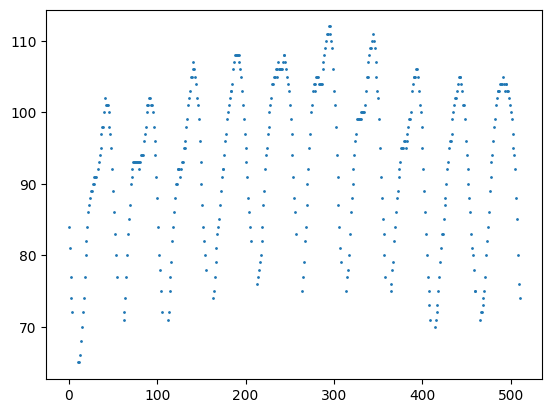

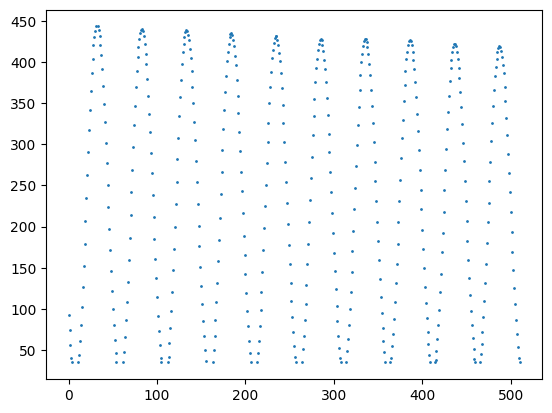

In [10]:
plt.scatter(frame, x, s=1)
plt.show()
plt.scatter(frame, y, s=1)
plt.show()

# Try fitting 
$A \sin(2\pi f t + \alpha)$

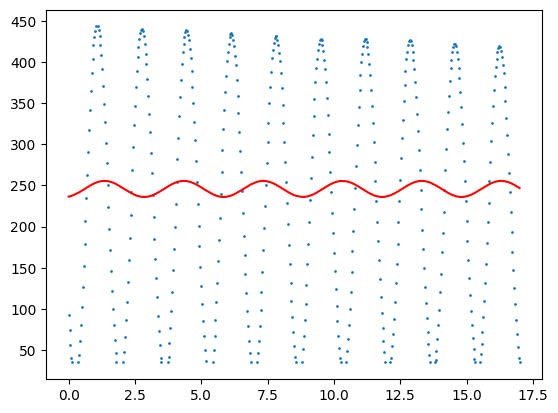

In [12]:
FPS = 30
t = frame / FPS


def func(t, A, f, alpha, offset):
    return A * np.sin(2 * np.pi * f * t + alpha) + offset


popt, pcov = curve_fit(func, t, x)
plt.scatter(t, x, s=1)
plt.plot(t, func(t, *popt), color="r", label="Best Fit")

In [13]:
r2_score(x, func(t, *popt))

0.0025434244429026753

# Oh no bad fit!

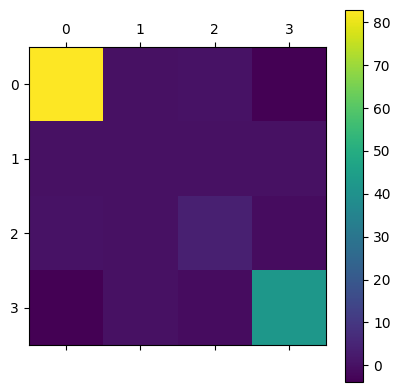

In [14]:
plt.matshow(pcov)
plt.colorbar()

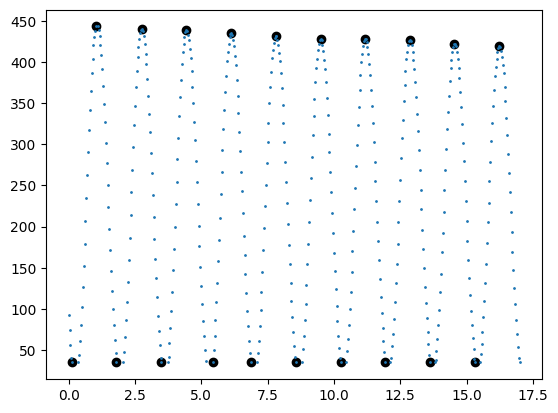

In [15]:
peaks, _ = find_peaks(x)
troughs, _ = find_peaks(-x)
crit_pts = np.append(peaks, troughs)
t_crit, x_crit = t[crit_pts], x[crit_pts]

plt.scatter(t_crit, x_crit, color="k", label="peaks")
plt.scatter(t, x, s=1)

period = np.mean(np.diff(sorted(t_crit))) * 2
freq = 1 / period

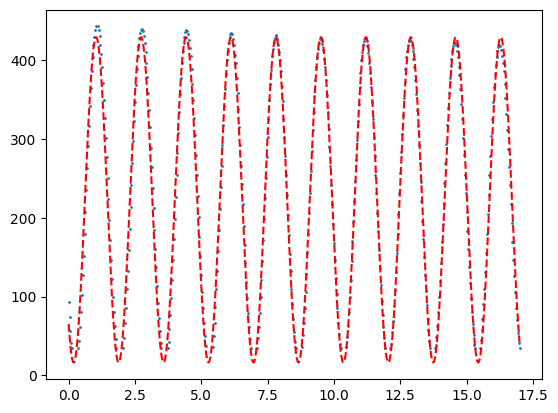

In [16]:
def func(t, A, alpha, offset):
    return A * np.sin(2 * np.pi * freq * t + alpha) + offset


t_lin = np.linspace(min(t), max(t), 1000)

popt, pcov = curve_fit(func, t, x)
plt.scatter(t, x, s=1)
plt.plot(t_lin, func(t_lin, *popt), color="r", linestyle="--", label="Best Fit")

In [17]:
r2_score(x, func(t, *popt))

0.9843027134434827

#### An underdamped pendulum decays in amplitude exponentially​  

\begin{align} \large \theta_{max}(t) = \theta_{0} e^{-\frac{\eta t}{2m}}  \end{align}

##### $ \eta $ : air drag constant ($ kg \cdot s^{-1} $)

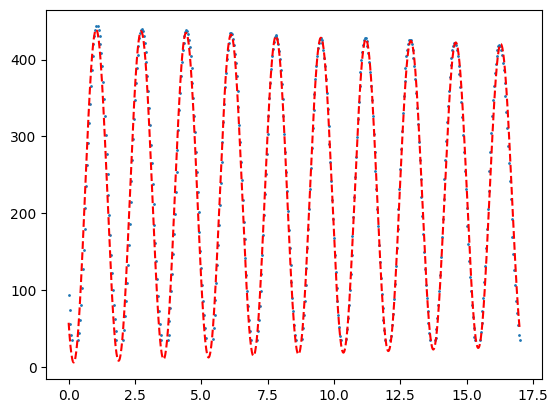

In [18]:
def func(t, A, alpha, offset, m):
    return A * (np.exp(m * t)) * np.sin(2 * np.pi * freq * t + alpha) + offset


t_lin = np.linspace(min(t), max(t), 1000)

popt, pcov = curve_fit(func, t, x)
plt.scatter(t, x, s=1)
plt.plot(t_lin, func(t_lin, *popt), color="r", linestyle="--", label="Best Fit")
plt.show()

In [19]:
r2_score(x, func(t, *popt))

0.9851694950296171

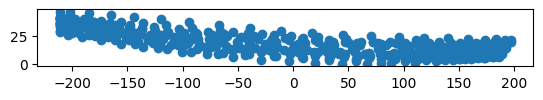

In [20]:
y_corr = np.max(y) - y
y_min = np.min(y_corr)
x_mean = np.mean(x)
x_disp = x - x_mean
y_disp = y_corr - y_min

plt.scatter(x_disp, y_disp)
plt.gca().set_aspect("equal")

In [21]:
xy = np.array([x_disp, y_disp]).T
rotation_matrix = lambda a: np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])


def rotate(a):
    return xy @ rotation_matrix(a).T


def error_fn(a):
    rotated_xy = rotate(a)
    rotated_y = rotated_xy[0, :, 1]
    return rotated_y


angle_estimate = 0
res = least_squares(error_fn, angle_estimate)
angle = res.x
np.rad2deg(angle)

array([3.63224987])

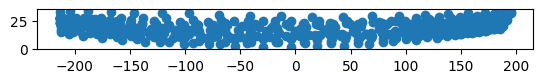

In [22]:
rotated_xy = rotate(angle)
x_rotated, y_rotated = rotated_xy[0].T
plt.scatter(x_rotated, y_rotated)
plt.gca().set_aspect("equal")

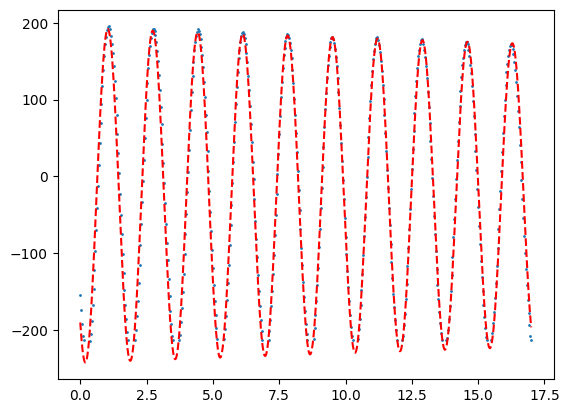

In [23]:
def func(t, A, alpha, offset, m):
    return A * (np.exp(m * t)) * np.sin(2 * np.pi * freq * t + alpha) + offset


t_lin = np.linspace(min(t), max(t), 1000)

popt, pcov = curve_fit(func, t, x_rotated)
plt.scatter(t, x_rotated, s=1)
plt.plot(t_lin, func(t_lin, *popt), color="r", linestyle="--", label="Best Fit")

In [24]:
r2_score(x_rotated, func(t, *popt))

0.9851828119488016

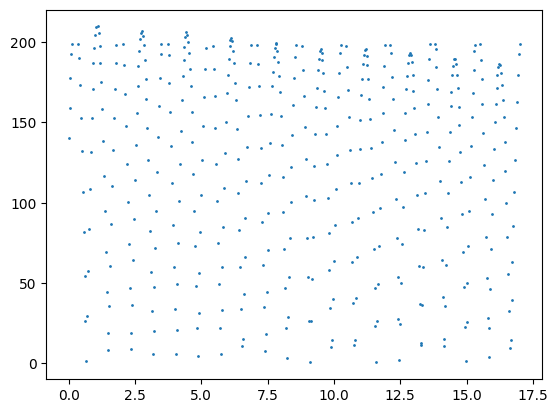

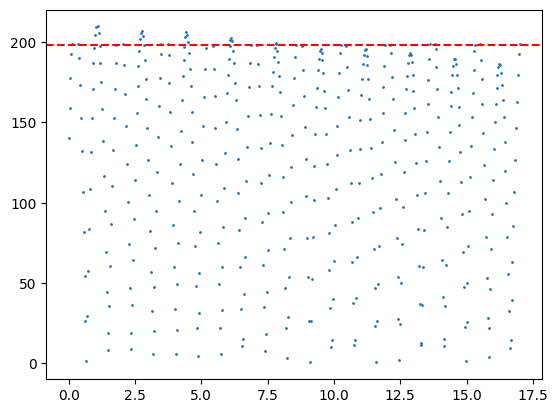

In [25]:
peaks, _ = find_peaks(x_rotated)
troughs, _ = find_peaks(-x_rotated)
crit_pts = np.append(peaks, troughs)

x_mean = np.mean(x_rotated[crit_pts])
x_disp = x_rotated - x_mean
x_cutoff = np.mean(x_rotated[troughs])

plt.scatter(t, np.abs(x_disp), s=1)
plt.show()
plt.scatter(t, np.abs(x_disp), s=1)
plt.axhline(np.abs(x_cutoff - x_mean), linestyle="--", color="r")
plt.show()